Data merged



C:\Users\Dennis\AppData\Local\Temp\ipykernel_13216\3007649077.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  filtered_data = filtered_data.groupby('Genmodel_ID').apply(sample_images).reset_index(drop=True)


Data filtered

Data split

Model compiled

Epoch 1/50
633/633 [==============================] - 94s 147ms/step - loss: 0.7550 - mae: 0.4979 - val_loss: 0.6420 - val_mae: 0.4602
Epoch 2/50
633/633 [==============================] - 68s 107ms/step - loss: 0.5691 - mae: 0.4367 - val_loss: 0.5699 - val_mae: 0.4449
Epoch 3/50
633/633 [==============================] - 71s 112ms/step - loss: 0.4675 - mae: 0.3972 - val_loss: 0.5191 - val_mae: 0.4272
Epoch 4/50
633/633 [==============================] - 71s 113ms/step - loss: 0.3899 - mae: 0.3667 - val_loss: 0.4828 - val_mae: 0.4128
Epoch 5/50
633/633 [==============================] - 72s 114ms/step - loss: 0.3257 - mae: 0.3397 - val_loss: 0.4522 - val_mae: 0.3950
Epoch 6/50
633/633 [==============================] - 73s 115ms/step - loss: 0.2719 - mae: 0.3157 - val_loss: 0.4327 - val_mae: 0.3797
Epoch 7/50
633/633 [==============================] - 75s 118ms/step - loss: 0.2264 - mae: 0.2935 - val_loss: 0.4162 - val_mae: 0.3688
Epoch 8/50
6

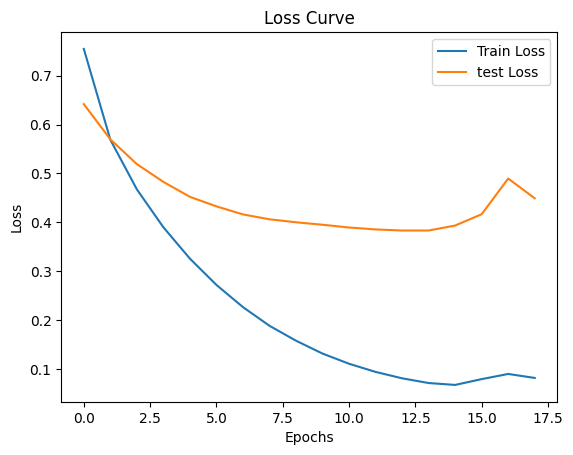

159/159 [==============================] - 15s 92ms/step - loss: 0.3832 - mae: 0.3408
Standardized MAE: 0.34078356623649597
159/159 [==============================] - 16s 98ms/step
Original MAE: 13513.858020610583
R² Score: 0.6123942278764944
Test sample number: 5060
1/1 [==============================] - 0s 206ms/step


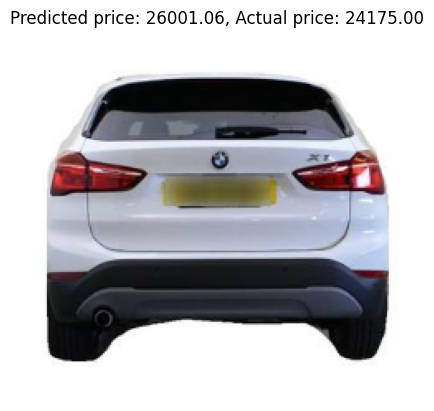

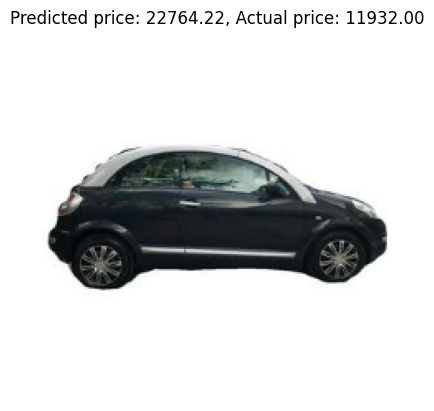

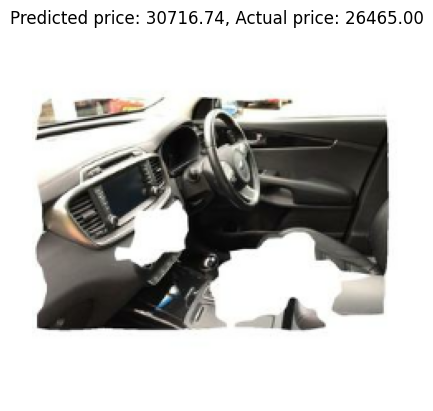

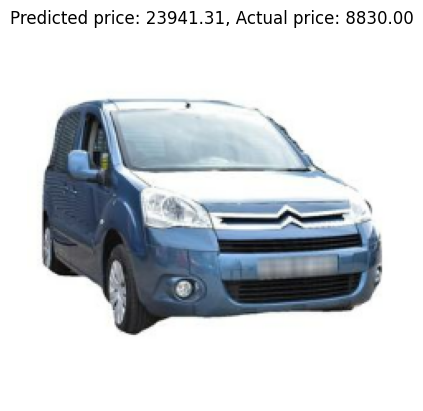

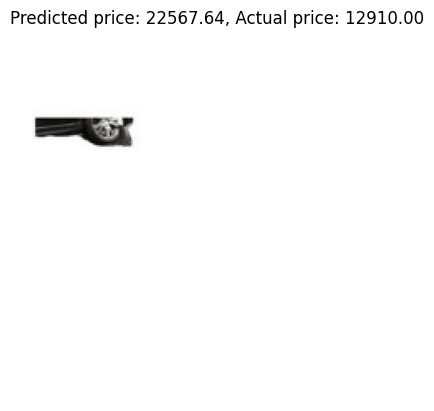

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Dense,
                                     Dropout, BatchNormalization, GlobalAveragePooling2D)
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pathlib import Path  # Import Path for checking file existence

image_table = pd.read_csv('D:\\CPEN355_project\\Data\\Image_table.csv')  
price_table = pd.read_csv('D:\\CPEN355_project\\Data\\Price_table.csv')  

# Merge the tables on 'Genmodel_ID' and keep relevant columns
merged_data = pd.merge(image_table[['Genmodel_ID', 'Image_name']],
                       price_table[['Genmodel_ID', 'Entry_price']],
                       on='Genmodel_ID')

print("Data merged\n")

#/////////////////////////Start filtering out dataset////////////////////////////////

# Count the number of images per Genmodel_ID
image_counts = merged_data['Genmodel_ID'].value_counts()

# Remove Genmodel_IDs with fewer than 200 images
valid_genmodels = image_counts[image_counts >= 200].index

# Filter merged_data to only include valid Genmodel_IDs
filtered_data = merged_data[merged_data['Genmodel_ID'].isin(valid_genmodels)]

# For Genmodel_IDs with counts > 200, randomly select 50 images
def sample_images(group):
    if len(group) > 200:
        return group.sample(n=50, random_state=42)
    else:
        return group

filtered_data = filtered_data.groupby('Genmodel_ID').apply(sample_images).reset_index(drop=True)

print("Data filtered\n")

#/////////////////////////End filtering out dataset////////////////////////////////


# Add full image paths to filtered_data
image_directory = 'D:\\CPEN355_project\\355DataSet\\DVM_noNest'  # Update with your image directory
filtered_data['Image_path'] = filtered_data['Image_name'].apply(
    lambda x: f"{image_directory}\\{x}"
)

# Check if images exist and filter out non-existent images
def image_exists(path):
    return Path(path).is_file()

exists_mask = filtered_data['Image_path'].apply(image_exists)
filtered_data = filtered_data[exists_mask].reset_index(drop=True)

# Now define image_paths and prices
image_paths = filtered_data['Image_path']
prices = filtered_data['Entry_price'].values

# Prepare image data and prices
img_size = 224  # Resize images to 128*128

scaler = StandardScaler()
prices_scaled = scaler.fit_transform(prices.reshape(-1, 1))

X_train_paths, X_test_paths, y_train_scaled, y_test_scaled = train_test_split(
    image_paths, prices_scaled, test_size=0.2, random_state=42)

print("Data split\n")

def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = image / 255.0
    return image, label

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_paths.values, y_train_scaled))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_paths.values, y_test_scaled))

train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False  # Freeze the VGG-16 layers

# Input layer
inputs = Input(shape=(img_size, img_size, 3))

# Pass inputs through the VGG-16 base model
x = base_model(inputs, training=False)

#x = Conv2D(32, (3, 3), activation='relu')(x)
#x = MaxPooling2D(2, 2)(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(2, 2)(x)

# x = BatchNormalization()(x)
# x = Dropout(0.5)(x)

# Flatten the output
x = Flatten()(x)

# Add Dense layers for regression
x = Dense(64, activation='relu')(x)
outputs = Dense(1)(x)  # Single output for regression

# Build the model
model = Model(inputs, outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])

print("Model compiled\n")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('pre-trained_cnn_model.h5', monitor='val_loss', save_best_only=True)

batch_size = 32  
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = model.fit(train_dataset, epochs=50,
                    validation_data=test_dataset,
                    callbacks=[early_stopping, model_checkpoint])

print("Finished training\n")

# Plotting loss curves
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss, mae = model.evaluate(test_dataset)

print(f"Standardized MAE: {mae}")

# Predictions and evaluation
predictions_scaled = model.predict(test_dataset)
predictions_scaled = np.concatenate(predictions_scaled, axis=0)
y_test_scaled_flat = np.concatenate([y for x, y in test_dataset], axis=0)

predictions = scaler.inverse_transform(predictions_scaled.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test_scaled_flat.reshape(-1, 1))

mae_original = mean_absolute_error(y_test, predictions)
#mse_original = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Original MAE: {mae_original}")
#print(f"Original MSE: {mse_original}")
print(f"R² Score: {r2}")
print("Test sample number:", len(y_test))

# Visualization code remains unchanged
test_images = []
test_labels = []
for image, label in test_dataset.unbatch().take(5):
    test_images.append(image.numpy())
    test_labels.append(label.numpy())

test_predictions = model.predict(np.array(test_images))
test_predictions = scaler.inverse_transform(test_predictions)

for i in range(len(test_images)):
    plt.imshow(test_images[i])
    plt.axis('off')

    actual_price = scaler.inverse_transform(test_labels[i].reshape(-1, 1))[0][0]
    predicted_price = test_predictions[i][0]
    plt.title(f"Predicted price: {predicted_price:.2f}, Actual price: {actual_price:.2f}")

    plt.show()